# House Price Regression Challenge 

## Steps
1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [713]:
#import libraries 

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sqlalchemy import create_engine
from sklearn import linear_model
import statsmodels.api as sm

import datetime

from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings 

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

warnings.filterwarnings('ignore')


## Load Dataset into a Dataframe
Here the house price dataset is downloaded from the database and CSV files are loaded from the census and the St. Louis federal reserve. The data from the CSV files is loaded into the dataframe.

In [714]:
## Load House price Dataset into a Dataframe
## https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
##credentials 
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

#create connection to database based on credentials 
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# create a dataframe from the imported data
house_price_data = pd.read_sql_query('select * from houseprices',con=engine)

#dispose of the connection 
engine.dispose()


In [715]:
##load Mortgage Rate CSV 
# from https://fred.stlouisfed.org/series/MORTGAGE30US

MORTGAGE30US_data = pd.read_csv('MORTGAGE30US.csv')
MORTGAGE30US_data['DATE']=pd.to_datetime(MORTGAGE30US_data['DATE'])
#MORTGAGE30US_data.tail(40)

MORTGAGE30US_data['Month_Number'] = MORTGAGE30US_data['DATE'].dt.month
MORTGAGE30US_data.tail(40)

# Getting year. month is common across years (as if you dont know :) )to we need to create unique index by using year and month
MORTGAGE30US_data['Year'] = MORTGAGE30US_data['DATE'].dt.year

MORTGAGE30US_data=MORTGAGE30US_data.groupby(['Year','Month_Number']).mean()
MORTGAGE30US_data = MORTGAGE30US_data.reset_index()
number_to_month= {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
MORTGAGE30US_data['Month_and_Year'] = MORTGAGE30US_data.Month_Number.map(number_to_month)+' '+MORTGAGE30US_data ['Year'].astype(str)
MORTGAGE30US_data['DATE'] = pd.to_datetime(MORTGAGE30US_data['Month_and_Year'])


In [716]:
#import Median and Average Monthly housing price data
US_monthly_price_data = pd.read_csv('Price -Table 1.csv')
US_monthly_price_data = US_monthly_price_data.rename(columns = {
    'Median and Average Sales Prices of New Homes Sold in United States':'Month_and_Year',
    'Unnamed: 1':'Median','Unnamed: 2':'Average' },)
US_monthly_price_data = US_monthly_price_data.drop(columns = ['Unnamed: 3','Unnamed: 4'])

US_monthly_price_data = US_monthly_price_data.drop([0,1,686,687])

#US_monthly_price_data.isnull().sum()*100/US_annual_price_data.isnull().count()
US_monthly_price_data.head()

US_monthly_price_data['Month_and_Year'] = pd.to_datetime(US_monthly_price_data['Month_and_Year'])

US_monthly_price_data['Median']=US_monthly_price_data['Median'].astype(str)
US_monthly_price_data['Median']=US_monthly_price_data['Median'].str.replace('$','')
US_monthly_price_data['Median']=US_monthly_price_data['Median'].str.replace(',','')
US_monthly_price_data['Median']=US_monthly_price_data['Median'].astype(float)

US_monthly_price_data['Average']=US_monthly_price_data['Average'].astype(str)
US_monthly_price_data['Average']=US_monthly_price_data['Average'].str.replace('$','')
US_monthly_price_data['Average']=US_monthly_price_data['Average'].str.replace(',','')
US_monthly_price_data['Average']=US_monthly_price_data['Average'].str.replace('(','')
US_monthly_price_data['Average']=US_monthly_price_data['Average'].str.replace(')','')
US_monthly_price_data['Average']=US_monthly_price_data['Average'].str.replace('NA','0')
US_monthly_price_data['Average']=US_monthly_price_data['Average'].astype(float)


In [717]:
#create new list of months and dates to compair to US housing data 
number_to_month= {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

house_price_data['Month_and_Year'] = house_price_data.mosold.map(number_to_month)+' '+house_price_data ['yrsold'].astype(str)

house_price_data['Month_and_Year'] = pd.to_datetime(house_price_data['Month_and_Year'])

#house_price_data['datime_mo_yr'].head()


#create lists to put data into 
thirty_yr_mortg_rate = []
median_mothly_homeprice=[]
avg_mothly_homeprice = []

for i in house_price_data['Month_and_Year']:
    
    thirty_yr_mortg_rate.extend(MORTGAGE30US_data.MORTGAGE30US.loc[MORTGAGE30US_data['DATE']==i])
    median_mothly_homeprice.extend(US_monthly_price_data.Median.loc[US_monthly_price_data['Month_and_Year']==i])
    avg_mothly_homeprice.extend(US_monthly_price_data.Average.loc[US_monthly_price_data['Month_and_Year']==i])


print(len(thirty_yr_mortg_rate))#,len(house_price_data['30yr_mortg_rate']) )
#house_price_data['datime_mo_yr'].describe()

#create new collumns in houseprice datafram from lists
house_price_data['30yr_mortg_rate'] = thirty_yr_mortg_rate
house_price_data['median_mothly_homeprice'] = median_mothly_homeprice
house_price_data['avg_mothly_homeprice'] = avg_mothly_homeprice

house_price_data.head()



1460


id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape landcontour utilities lotconfig landslope neighborhood condition1 condition2 bldgtype housestyle  overallqual  overallcond  yearbuilt  yearremodadd roofstyle roofmatl exterior1st exterior2nd masvnrtype  masvnrarea exterqual extercond foundation bsmtqual bsmtcond bsmtexposure bsmtfintype1  bsmtfinsf1 bsmtfintype2  bsmtfinsf2  bsmtunfsf  totalbsmtsf heating heatingqc centralair electrical  firstflrsf  secondflrsf  lowqualfinsf  grlivarea  bsmtfullbath  bsmthalfbath  fullbath  halfbath  bedroomabvgr  kitchenabvgr kitchenqual  totrmsabvgrd functional  fireplaces fireplacequ garagetype  garageyrblt garagefinish  garagecars  garagearea garagequal garagecond paveddrive  wooddecksf  openporchsf  enclosedporch  threessnporch  screenporch  poolarea poolqc fence miscfeature  miscval  mosold  yrsold saletype salecondition  saleprice Month_and_Year  30yr_mortg_rate  median_mothly_homeprice  avg_mothly_homeprice
0   1          60       RL         65.0     8450   Pave  None      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2003          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA      PConc       Gd       TA           No          GLQ         706          Unf           0        150          856    GasA        Ex          Y      SBrkr         856          854             0       1710             1             0         2         1             3             1          Gd             8        Typ           0        None     Attchd       2003.0          RFn           2         548         TA         TA          Y           0           61              0              0            0         0   None  None        None        0       2    2008       WD        Normal     208500     2008-02-01           5.9175                 245300.0              301200.0
1   2          20       RL         80.0     9600   Pave  None      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story            6            8       1976          1976     Gable  CompShg     MetalSd     MetalSd       None         0.0        TA        TA     CBlock       Gd       TA           Gd          ALQ         978          Unf           0        284         1262    GasA        Ex          Y      SBrkr        1262            0             0       1262             0             1         2         0             3             1          TA             6        Typ           1          TA     Attchd       1976.0          RFn           2         460         TA         TA          Y         298            0              0              0            0         0   None  None        None        0       5    2007       WD        Normal     181500     2007-05-01           6.2620                 245000.0              309700.0
2   3          60       RL         68.0    11250   Pave  None      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2001          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA      PConc       Gd       TA           Mn          GLQ         486          Unf           0        434          920    GasA        Ex          Y      SBrkr         920          866             0       1786             1             0         2         1             3             1          Gd             6        Typ           1          TA     Attchd       2001.0          RFn           2         608         TA         TA          Y           0           42              0              0            0         0   None  None        None        0       9    2008       WD        Normal     223500     2008-09-01           6.0375                 225200.0              287100.0
3   4          70       RL         60.0     9550   Pave  None      IR1 

## Data Cleaning 

In [718]:
#Create a new dataframe with Null,nan, and Zero Value counts for each variable 
nans = house_price_data.isin([np.nan]).sum()
nulls = house_price_data.isnull().sum()
zeros = house_price_data.isin([0]).sum()

null_df =  pd.DataFrame()
null_df['nulls'] = nulls
null_df['nans'] = nans
null_df['zeros'] = zeros
#transpose dataframe 
null_df = null_df.T

#pd.set_option(optname, val)
null_df.head()


id  mssubclass  mszoning  lotfrontage  lotarea  street  alley  lotshape  landcontour  utilities  lotconfig  landslope  neighborhood  condition1  condition2  bldgtype  housestyle  overallqual  overallcond  yearbuilt  yearremodadd  roofstyle  roofmatl  exterior1st  exterior2nd  masvnrtype  masvnrarea  exterqual  extercond  foundation  bsmtqual  bsmtcond  bsmtexposure  bsmtfintype1  bsmtfinsf1  bsmtfintype2  bsmtfinsf2  bsmtunfsf  totalbsmtsf  heating  heatingqc  centralair  electrical  firstflrsf  secondflrsf  lowqualfinsf  grlivarea  bsmtfullbath  bsmthalfbath  fullbath  halfbath  bedroomabvgr  kitchenabvgr  kitchenqual  totrmsabvgrd  functional  fireplaces  fireplacequ  garagetype  garageyrblt  garagefinish  garagecars  garagearea  garagequal  garagecond  paveddrive  wooddecksf  openporchsf  enclosedporch  threessnporch  screenporch  poolarea  poolqc  fence  miscfeature  miscval  mosold  yrsold  saletype  salecondition  saleprice  Month_and_Year  30yr_mortg_rate  \
nulls   0           0         0          259        0       0   1369         0            0          0          0          0             0           0           0         0           0            0            0          0             0          0         0            0            0           8           8          0          0           0        37        37            38            37           0            38           0          0            0        0          0           0           1           0            0             0          0             0             0         0         0             0             0            0             0           0           0          690          81           81            81           0           0          81          81           0           0            0              0              0            0         0    1453   1179         1406        0       0       0         0              0          0               0                0   
nans    0           0         0          259        0       0      0         0            0          0          0          0             0           0           0         0           0            0            0          0             0          0         0            0            0           0           8          0          0           0         0         0             0             0           0             0           0          0            0        0          0           0           0           0            0             0          0             0             0         0         0             0             0            0             0           0           0            0           0           81             0           0           0           0           0           0           0            0              0              0            0         0       0      0            0        0       0       0         0              0          0               0                0   
zeros   0           0         0            0        0       0      0         0            0          0          0          0             0           0           0         0           0            0            0          0             0          0         0            0            0           0         861          0          0           0         0         0             0             0         467             0        1293        118           37        0          0           0           0           0          829          1434          0           856          1378         9       913             6             1            0             0           0         690            0           0            0             0          81          81           0           0           0         761          656           1252           1436         1344      1453       0      0            0     1408       0       0         0              0          0               0                0   

       median_mothly_homeprice  avg_mothly_homeprice  
nul

As can be seen in the table above, many of the variables have null values, however, when examining the description of these variables many of them would not exist in every house being sold. For example a home that doesn't have a secound floor will not have a square footage value associated with the second floor, same thing with fireplaces etcetra., The variables that are essential(e.g. first floor, neighborhood, and lot area) appear to be complete with no missing data.  
In order to make the continuous variables usable for feature generation, their null values will be replaced with zero so that they can be used. 

In [719]:
#create a list of the continuous variables 
continuous_variabels =['id','mssubclass',
                       'lotfrontage','lotarea','overallqual','overallcond','yearbuilt','yearremodadd'
                        ,'masvnrarea' ,'bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','firstflrsf'       
                        ,'secondflrsf','lowqualfinsf','grlivarea','bsmtfullbath','bsmthalfbath','fullbath'        
                        ,'halfbath','bedroomabvgr','kitchenabvgr','totrmsabvgrd','fireplaces', 'garageyrblt'
                        ,'garagecars','garagearea', 'wooddecksf','openporchsf','enclosedporch'    
                        ,'threessnporch','screenporch','poolarea','miscval','mosold','yrsold','saleprice'
                        ,'30yr_mortg_rate' ,'median_mothly_homeprice','avg_mothly_homeprice','Month_and_Year']



#create a list of catagorica variables 
house_price_data_catagorical=house_price_data.drop(continuous_variabels, axis = 1)

catagories = house_price_data_catagorical.columns 


In [720]:
#Fill the null values for continuous variables with zero. 
house_price_data[['mssubclass',
                       'lotfrontage','lotarea','overallqual','overallcond','yearbuilt','yearremodadd'
                        ,'masvnrarea' ,'bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','firstflrsf'       
                        ,'secondflrsf','lowqualfinsf','grlivarea','bsmtfullbath','bsmthalfbath','fullbath'        
                        ,'halfbath','bedroomabvgr','kitchenabvgr','totrmsabvgrd','fireplaces' 
                        ,'garagecars','garagearea', 'wooddecksf','openporchsf','enclosedporch'    
                        ,'threessnporch','screenporch','poolarea','miscval','mosold','yrsold','saleprice'
                        ,'30yr_mortg_rate' ,'median_mothly_homeprice','avg_mothly_homeprice']] = house_price_data[['mssubclass',
                       'lotfrontage','lotarea','overallqual','overallcond','yearbuilt','yearremodadd'
                        ,'masvnrarea' ,'bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','firstflrsf'       
                        ,'secondflrsf','lowqualfinsf','grlivarea','bsmtfullbath','bsmthalfbath','fullbath'        
                        ,'halfbath','bedroomabvgr','kitchenabvgr','totrmsabvgrd','fireplaces'
                        ,'garagecars','garagearea', 'wooddecksf','openporchsf','enclosedporch'    
                        ,'threessnporch','screenporch','poolarea','miscval','mosold','yrsold','saleprice'
                        ,'30yr_mortg_rate' ,'median_mothly_homeprice','avg_mothly_homeprice']].fillna(0)


## Data Exploration

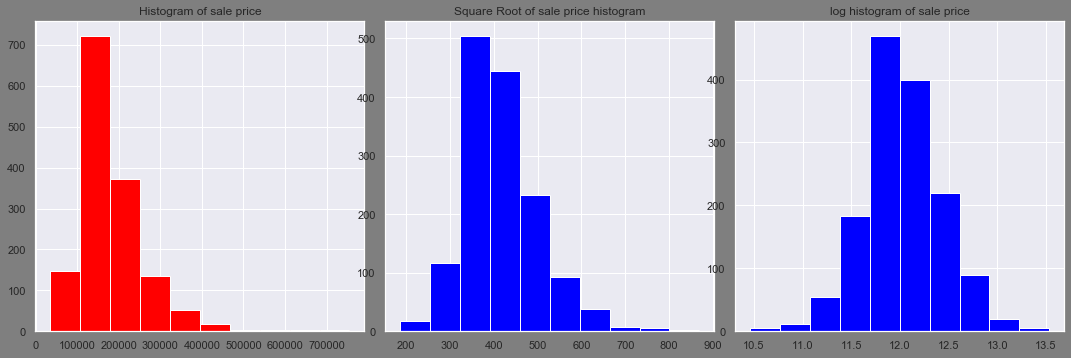

In [721]:
# Target Feature 

house_price_data["log_saleprice"] = np.log(house_price_data['saleprice'])
house_price_data["sqrt_saleprice"] = np.sqrt(house_price_data['saleprice'])


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.tight_layout()
plt.hist(house_price_data['saleprice'],color ='red')
plt.title('Histogram of sale price')

plt.subplot(1,3,2)
plt.hist(house_price_data["sqrt_saleprice"],color ='blue')
plt.title('Square Root of sale price histogram')

plt.subplot(1,3,3)
plt.hist(house_price_data["log_saleprice"],color ='blue')
plt.title('log histogram of sale price')

#plt.hist(house_price_data['saleprice'],color ='red')
plt.show()


Above are histograms of the target feature sale price the center histogram is the square root of the saleprices and the right histogram is the log of the sale prices.  

In [722]:
# create new and transformed variabels to explore

#transform general living area 
house_price_data['sqrt_grllivarea'] = np.sqrt(house_price_data['grlivarea'])
house_price_data["log_grllivarea"] = np.log(house_price_data['grlivarea'])

#create new varaiable total space and transform it with squarroot and log 
house_price_data["total_space"] = house_price_data['totalbsmtsf']+house_price_data['firstflrsf']+house_price_data['secondflrsf']
house_price_data["sqrt_total_space"] = np.sqrt(house_price_data['total_space'])
house_price_data["log_total_space"] = np.log(house_price_data['total_space'])

#create a new variable called outdoor space 
house_price_data["outdoor_space"] =house_price_data['lotarea']- house_price_data['firstflrsf']

house_price_data['tot_fullbath']=house_price_data['fullbath']+ house_price_data['bsmtfullbath']

house_price_data['tot_halfbath']=house_price_data['halfbath']+ house_price_data['bsmthalfbath']
#transform lot area 
house_price_data["sqrt_lotarea"] = np.sqrt(house_price_data['lotarea'])
house_price_data["log_lotarea"] = np.log(house_price_data['lotarea'])


house_price_data["sqrt_yearbuilt"] = np.sqrt(house_price_data['yearbuilt'])


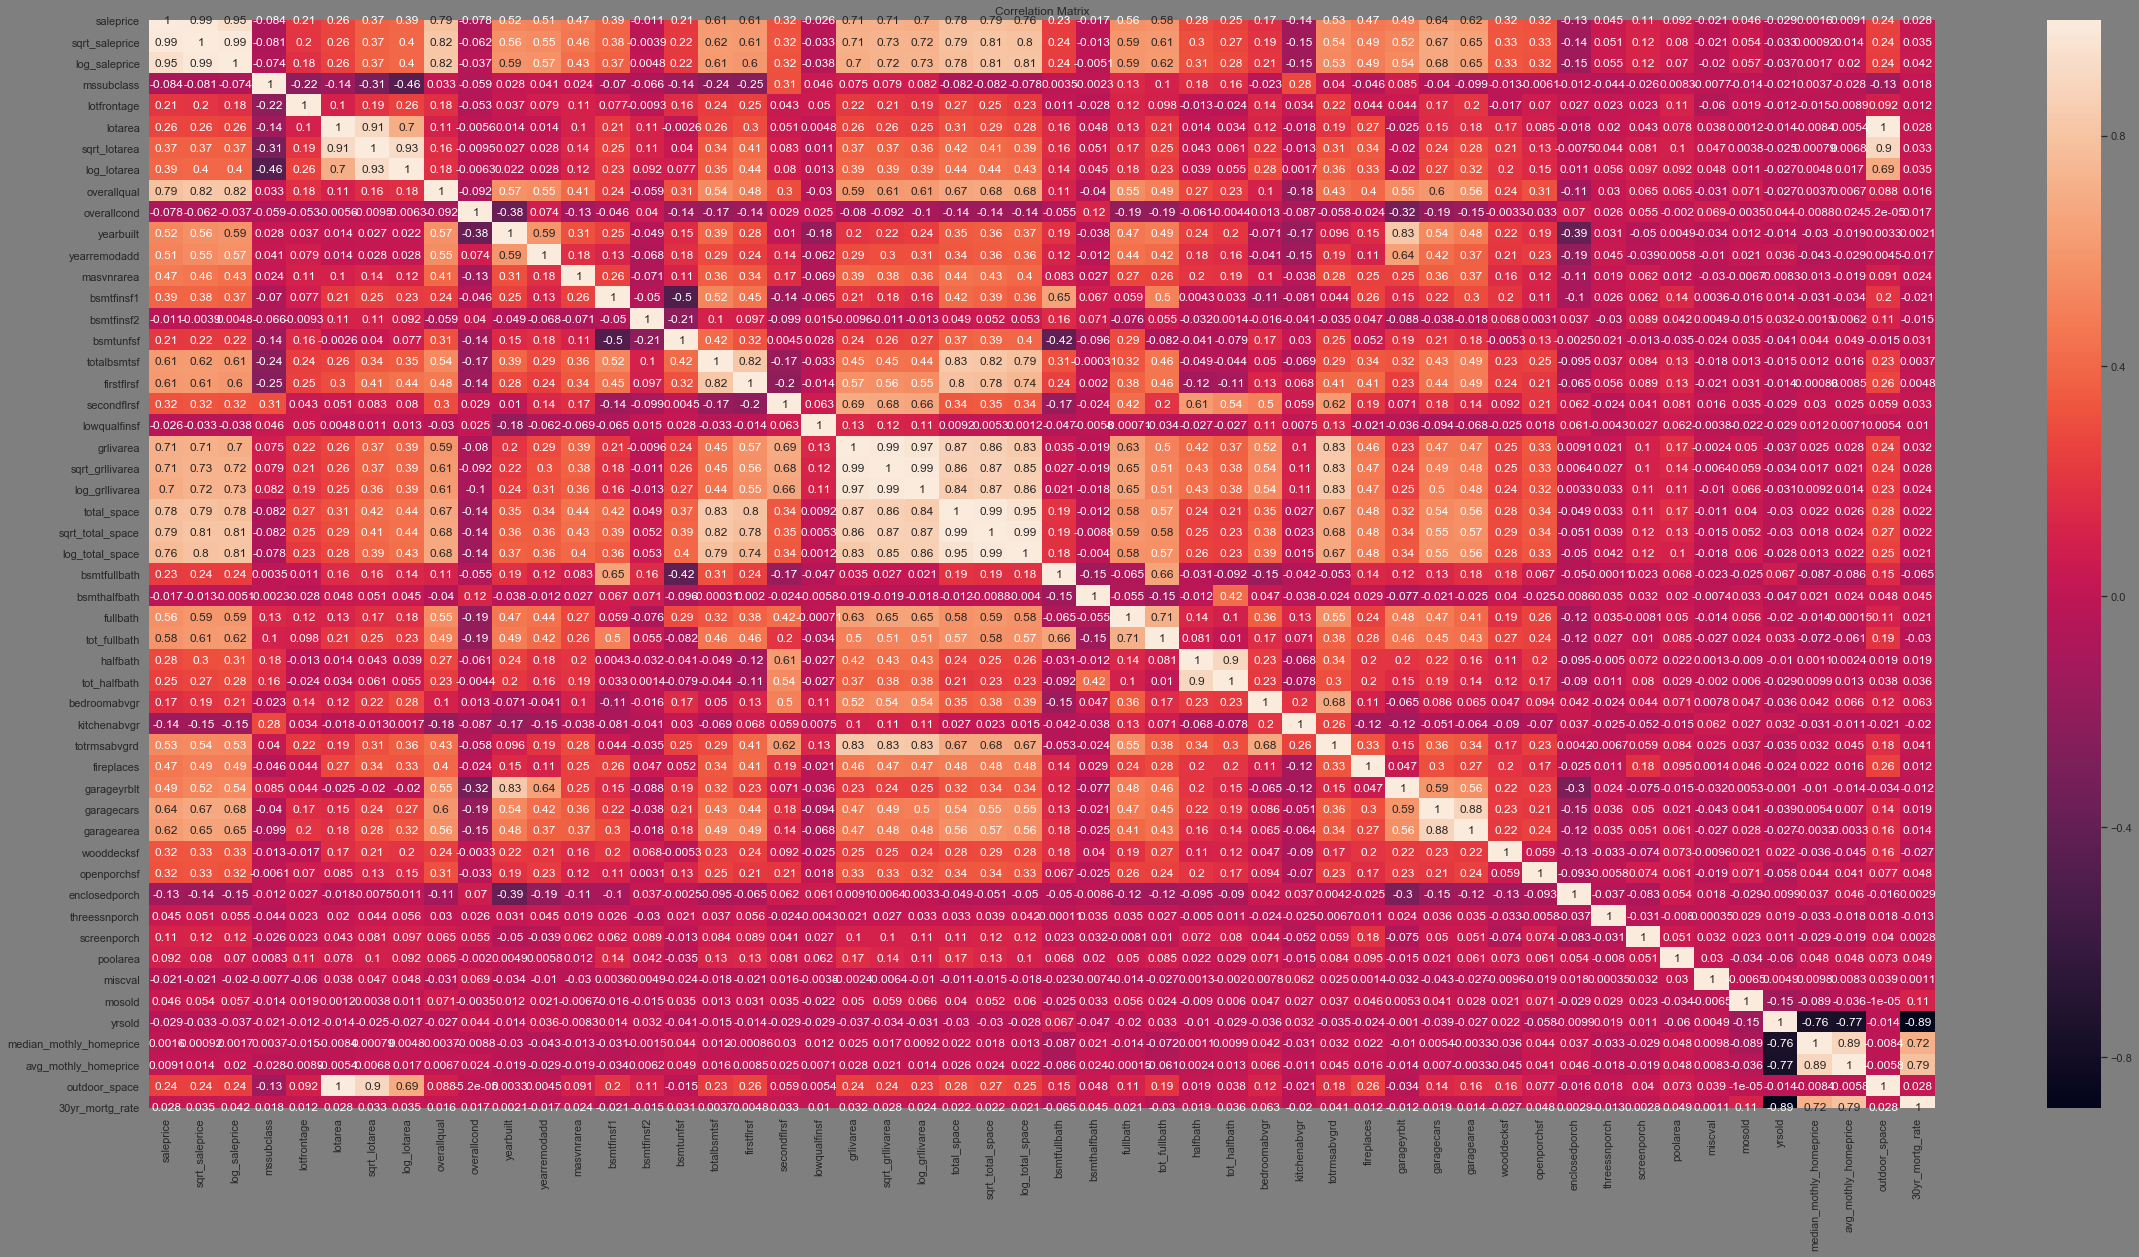

In [723]:
#create a heat map of continuous variables 
plt.figure(figsize=(40,20))
sns.set(rc={ 'figure.facecolor':'tab:gray'})
heat_corr = house_price_data[['saleprice','sqrt_saleprice','log_saleprice',
                              'mssubclass','lotfrontage','lotarea','sqrt_lotarea', 'log_lotarea'
                              ,'overallqual','overallcond','yearbuilt','yearremodadd'
                              ,'masvnrarea' ,'bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','firstflrsf'       
                                ,'secondflrsf','lowqualfinsf','grlivarea','sqrt_grllivarea','log_grllivarea'
                                ,'total_space', 'sqrt_total_space', 'log_total_space','bsmtfullbath','bsmthalfbath','fullbath','tot_fullbath'       
                                ,'halfbath','tot_halfbath','bedroomabvgr','kitchenabvgr','totrmsabvgrd','fireplaces','garageyrblt'
                                ,'garagecars','garagearea', 'wooddecksf','openporchsf','enclosedporch'    
                                ,'threessnporch','screenporch','poolarea','miscval','mosold','yrsold'
                                ,'median_mothly_homeprice','avg_mothly_homeprice','Month_and_Year'
                                ,'outdoor_space','30yr_mortg_rate'


]].corr()
sns.heatmap(heat_corr, annot=True) 
plt.title("Correlation Matrix")
plt.show()

The correlation matrix above shows two promissing variables, the overall quality, and the square root of the total area in square feet. The correlation of these variables with sale price makes sense since larger homes are more expensive in material and labor costs and the quality of that home gives us the value of that space. 

In addition, other variables that show moderate correlation include the remodeling year, number of car spaces in the garage, the year the garage was built, the number of fireplaces, the total number of full bathrooms, and the year the house was built. 

Unfortunatly the added variables of mortgage rates and home prices did not yield any correlation 


## Principle Component Analysis 

In [724]:
house_price_precomponents =  house_price_data[['mssubclass', 'lotarea'
                              ,'overallqual','overallcond','yearremodadd'
                               ,'bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','firstflrsf'       
                                ,'secondflrsf','lowqualfinsf','grlivarea'
                                ,'total_space','bsmtfullbath','bsmthalfbath','fullbath'       
                                ,'bedroomabvgr','kitchenabvgr','totrmsabvgrd','fireplaces'
                                ,'garagecars','garagearea', 'wooddecksf','openporchsf','enclosedporch'    
                                ,'threessnporch','screenporch','poolarea','miscval' ]]


In [725]:
house_price_precomponents.fillna(0)
house_price_precomponents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 30 columns):
mssubclass       1460 non-null int64
lotarea          1460 non-null int64
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearremodadd     1460 non-null int64
bsmtfinsf1       1460 non-null int64
bsmtfinsf2       1460 non-null int64
bsmtunfsf        1460 non-null int64
totalbsmtsf      1460 non-null int64
firstflrsf       1460 non-null int64
secondflrsf      1460 non-null int64
lowqualfinsf     1460 non-null int64
grlivarea        1460 non-null int64
total_space      1460 non-null int64
bsmtfullbath     1460 non-null int64
bsmthalfbath     1460 non-null int64
fullbath         1460 non-null int64
bedroomabvgr     1460 non-null int64
kitchenabvgr     1460 non-null int64
totrmsabvgrd     1460 non-null int64
fireplaces       1460 non-null int64
garagecars       1460 non-null int64
garagearea       1460 non-null int64
wooddecksf       1460 non-null int64
openp

In [726]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(house_price_precomponents)


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.22875731 0.09852977 0.0653709  0.05703593 0.04738109 0.03761616
 0.03638604 0.03538951 0.0340982  0.0335898 ]


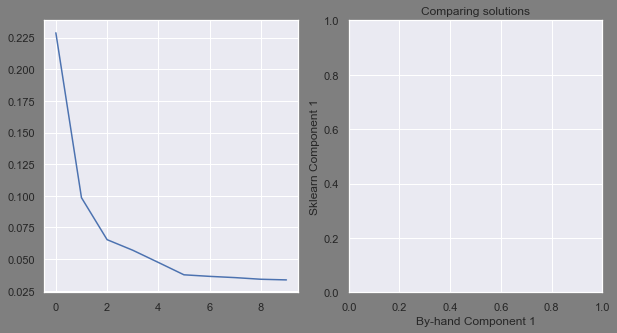

In [727]:
sklearn_pca = PCA(n_components=10)
Y_sklearn = sklearn_pca.fit_transform(X)



print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(sklearn_pca.explained_variance_ratio_)
plt.subplot(1,2,2)
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()


In [728]:
for n in range(5):
    house_price_data['PC{}'.format(n+1)]= Y_sklearn[:, n]


house_price_data[['PC1','PC2','PC3','PC4','PC5','saleprice','sqrt_saleprice','log_saleprice']].corr()




PC1           PC2           PC3           PC4           PC5  saleprice  sqrt_saleprice  log_saleprice
PC1             1.000000e+00 -1.185228e-17 -1.409501e-18  2.375533e-17 -4.964969e-17   0.851715        0.873476       0.869550
PC2            -1.185228e-17  1.000000e+00 -1.035939e-17 -3.401544e-17 -3.205262e-17  -0.106276       -0.105320      -0.100784
PC3            -1.409501e-18 -1.035939e-17  1.000000e+00  6.246252e-16 -2.551435e-16  -0.036687       -0.049407      -0.055478
PC4             2.375533e-17 -3.401544e-17  6.246252e-16  1.000000e+00 -9.440450e-17  -0.129569       -0.150212      -0.164607
PC5            -4.964969e-17 -3.205262e-17 -2.551435e-16 -9.440450e-17  1.000000e+00  -0.120160       -0.141089      -0.159271
saleprice       8.517154e-01 -1.062760e-01 -3.668733e-02 -1.295686e-01 -1.201596e-01   1.000000        0.986806       0.948374
sqrt_saleprice  8.734765e-01 -1.053198e-01 -4.940721e-02 -1.502122e-01 -1.410892e-01   0.986806        1.000000       0.986696
log_saleprice   8.695502e-01 -1.007838e-01 -5.547843e-02 -1.646073e-01 -1.592707e-01   0.948374        0.986696       1.000000

## PCA Results 
The PCA yielded a poor amount of explained variance(<50%) from the continuous variables that were incorperated. Though the first principle component does show a high correlation with the target variable. 


<Figure size 432x288 with 0 Axes>

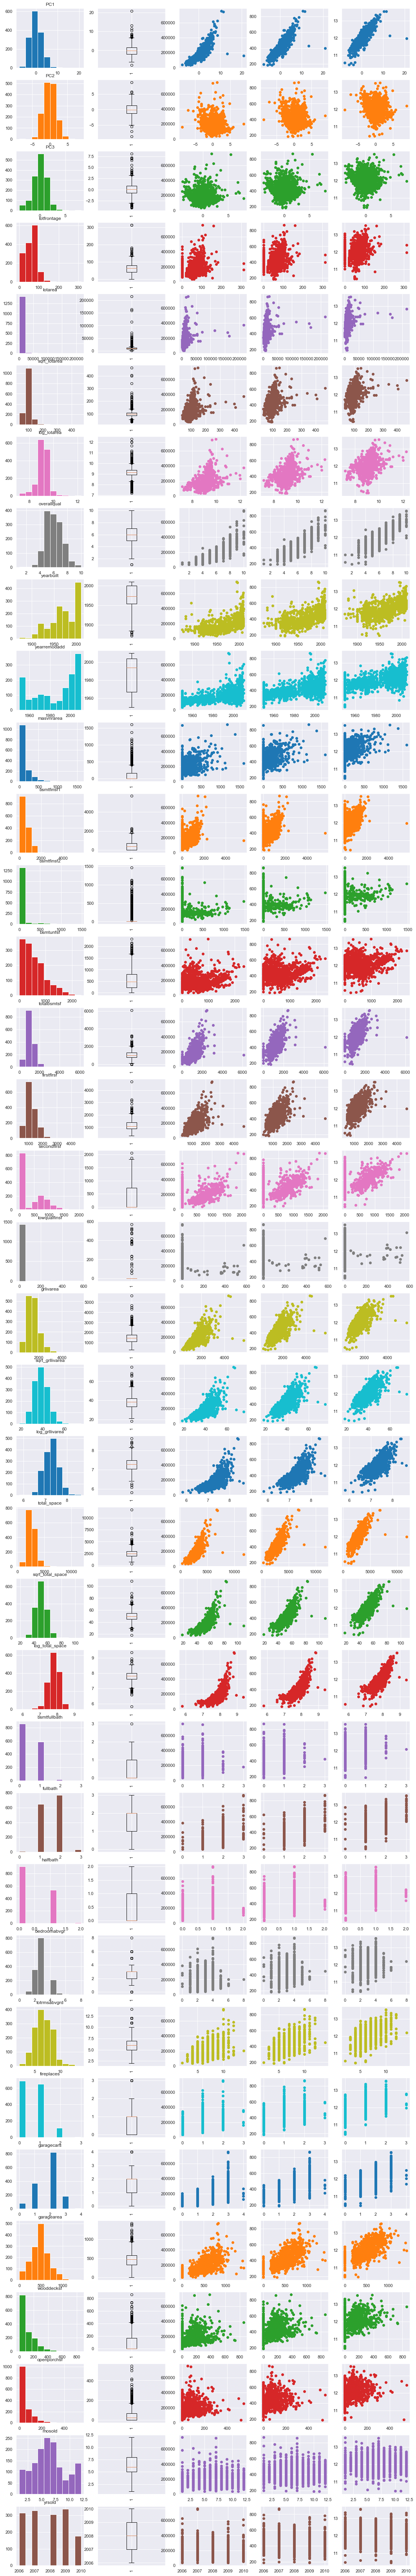

In [775]:
cont_vars =[ 'PC1','PC2','PC3','lotfrontage','lotarea','sqrt_lotarea', 'log_lotarea'
                              ,'overallqual','yearbuilt','yearremodadd'
                              ,'masvnrarea' ,'bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','firstflrsf'       
                                ,'secondflrsf','lowqualfinsf','grlivarea','sqrt_grllivarea','log_grllivarea'
                                ,'total_space', 'sqrt_total_space', 'log_total_space','bsmtfullbath','fullbath'       
                                ,'halfbath','bedroomabvgr','totrmsabvgrd','fireplaces' 
                                ,'garagecars','garagearea', 'wooddecksf','openporchsf','mosold', 'yrsold']

plt.tight_layout()
sns.set(rc={ 'figure.facecolor':'white'})

plt.figure(figsize=(18,120))
colorlist = ['tab:blue','tab:orange','tab:green','tab:red',
             'tab:purple','tab:brown','tab:pink',
             'tab:grey','tab:olive','tab:cyan']

log_price = np.log(house_price_data['saleprice'])

p=0
n=0
for i, var in enumerate (cont_vars,1):

    p=i*5
    c = colorlist[n]
    if n > len(colorlist)-2:
        n=0
    else:
        n+=1
        
    plt.subplot(len(cont_vars),5,p-4)
    plt.hist(house_price_data[var],color = c)
    plt.title(var)
   
    plt.subplot(len(cont_vars),5,p-3)
    plt.boxplot(house_price_data[var])
    plt.xticks(rotation='vertical')
    
    plt.subplot(len(cont_vars),5,p-2)
    plt.scatter(house_price_data[var],y = house_price_data['saleprice'], color = c)
    
    plt.subplot(len(cont_vars),5,p-1)
    plt.scatter(house_price_data[var],y = house_price_data['sqrt_saleprice'], color = c)
    
    plt.subplot(len(cont_vars),5,p)
    plt.scatter(house_price_data[var],y = house_price_data['log_saleprice'], color = c)
    
plt.show()    


Several varaiables appear quite useful and might assist in explaining some of the variance in the target variable of sale price. As seen in the correlation matrix, total space and overall quality correlate in a very clean manner with sale price. 

Year built shows a moderate correlation with preference given to new homes. This is understandable because customers may not want to deal with the necessary updates and problems that can come with older homes. Some of the outliers built in earlier years, may have been well maintained and likely have particular features rare in new homes. 

Full bathrooms are often a strong selling point especially for families. The idea of having to share fewer bathrooms with family members, can dissuade home buyers. This explains the correlation of total number of full bathrooms. 

Fire places are often a luxury feature that come with homes. 

Lot area only correlated slightly with sale price . This was a surprise to me and was counter to intuition and the advice I had recieved when purchasing a home myself. I have encountered many situations where the land a house was built on was worth more than the home. Resulting in situations where functioning homes in great condition, were torn down to build new houses and buildings on the lot. This lack of correlation might be explained by interactions with other features such as location and geological features.

The number of cars a garage can hold is likely an indicator of income. Garages are a luxury feature of a home as most cars could be parked in the open. Garages are a way to care for vehicles and the more vehicles a family can own and care for the more likely it is that they have disposable income.  


The year the house was remodeled likely has an influence on price since buyers often prefer to have homes with updated and modern amenities. 
 

The total number of rooms above grade in a home shows a slight correlation with home price. This coorelation is likely because a higher number of rooms provide privacy for occupants and allow home owners to compartmentalize certain functions: eating, leisure activity, office work, and sleeping.  


In [730]:
sns.set(rc={ 'figure.facecolor':'white'})

plt.tight_layout
plt.figure(figsize=(60,300))

house_price_data = house_price_data.sort_values(by='saleprice',ascending=True)

for i, catagory in enumerate (catagories,1):
    

    
    
    p=i*4
    len(catagories)
    plt.subplot(len(catagories),4,p-3)
    plt.bar(house_price_data.groupby(catagory)['saleprice'].count().index,
        house_price_data.groupby(catagory)["saleprice"].count(),
        color=("blue","pink","green","orange"))
    plt.title('{} counts'.format(catagory))
    #plt.xlabel(catagory)
    plt.xticks(rotation=25)
    
    plt.subplot(len(catagories),4,p-2)
    plt.bar(house_price_data.groupby(catagory)['saleprice'].median().index,
        house_price_data.groupby(catagory)["saleprice"].median(),
        color=("blue","pink","green","orange"))
    plt.title('{} vs saleprice'.format(catagory))
    #plt.xlabel(catagory)
    plt.xticks(rotation=25)
    
    plt.subplot(len(catagories),4,p-1)
    plt.bar(house_price_data.groupby(catagory)['sqrt_saleprice'].median().index,
        house_price_data.groupby(catagory)["sqrt_saleprice"].median(),
        color=("blue","pink","green","orange"))
    plt.title('{} vs square root saleprice'.format(catagory))
    #plt.xlabel(catagory)
    plt.xticks(rotation=25)

    plt.subplot(len(catagories),4,p)
    plt.bar(house_price_data.groupby(catagory)['log_saleprice'].median().index,
        house_price_data.groupby(catagory)["log_saleprice"].median(),
        color=("blue","pink","green","orange"))
    plt.title('{} vs log saleprice'.format(catagory),loc='right')
    #plt.xlabel(catagory)
    plt.xticks(rotation=25)

                                                                                                                   
                                                                                                                   

in examining the bar plots of the catagories above several catagorical variabels stand out 
neighborhood and landslope are variables I would like to explore further because they may have an interaction with lot area. 

other variables that show strong price differences by catagory are. 
,'kitchenqual','fireplacequ','exterior1st','exterqual','electrical','garagefinish',
'foundation','bsmtqual','bsmtcond'

In the cell below ANOVAs are conducted onthe varibles listed above and the values are displayed in a heat map matrix to allow qucik identification.Tthe catgroies are sorted by their mean saleprice. 


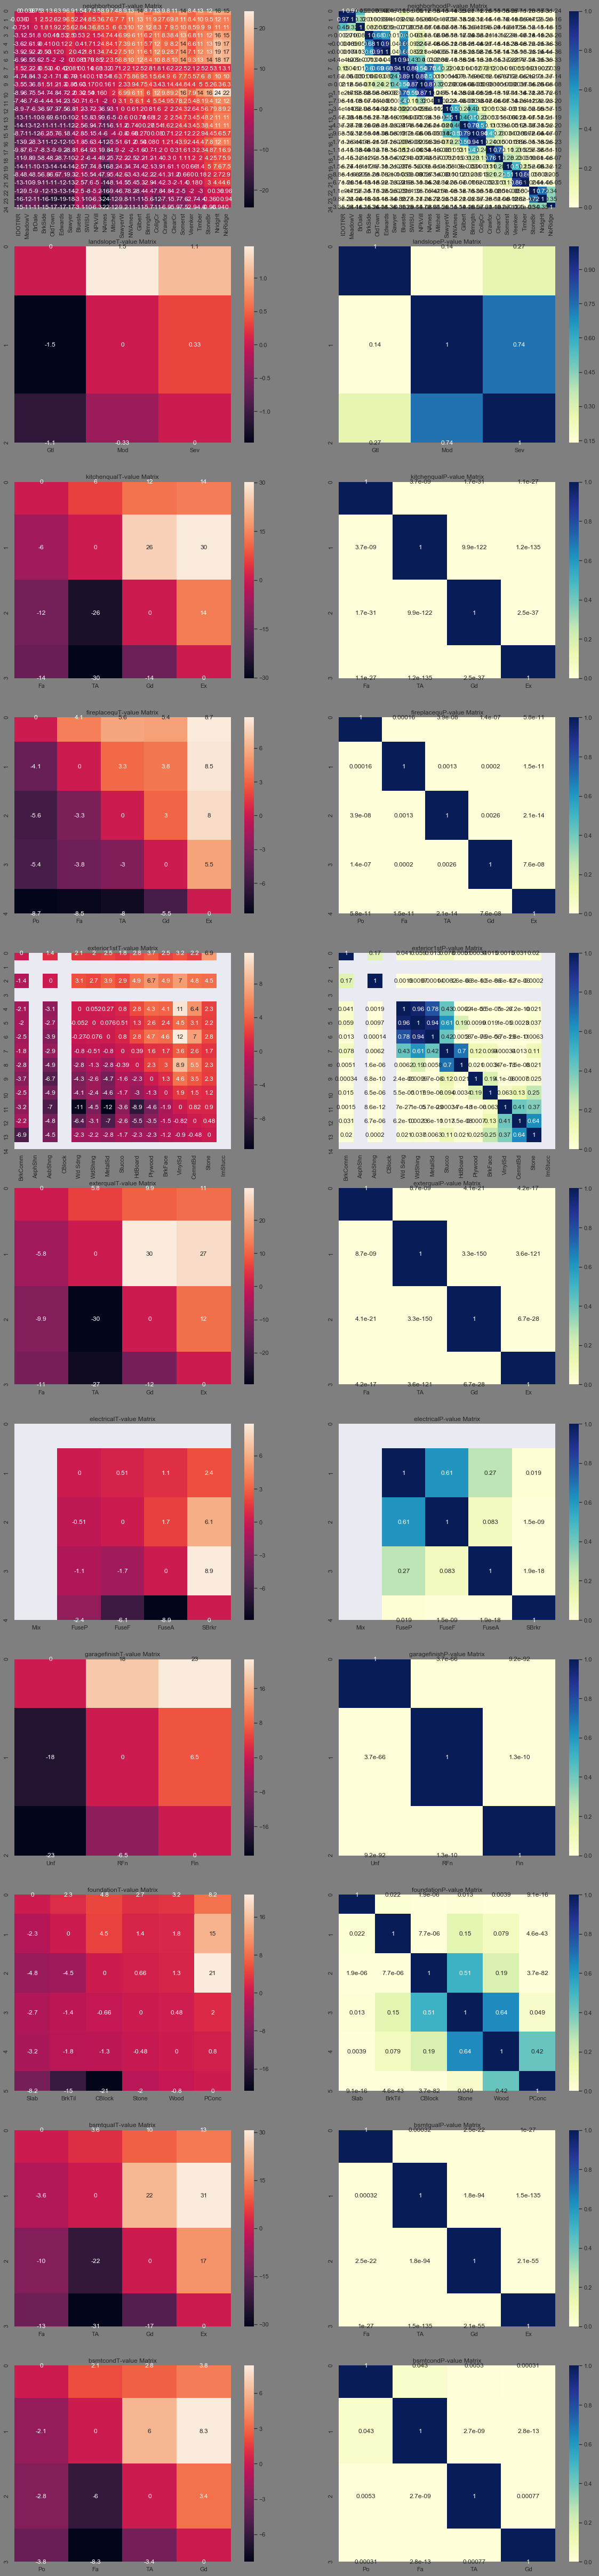

In [744]:
catagorical_feature_list = ['neighborhood','landslope','kitchenqual','fireplacequ',
'exterior1st','exterqual','electrical','garagefinish',
'foundation','bsmtqual','bsmtcond']

p=0
plt.figure(figsize=(20,88))

for n, catagorical_variable in enumerate (catagorical_feature_list):


    #create list catagories for the catagorical variable
    catagories = house_price_data.groupby(catagorical_variable)["sqrt_saleprice"].mean().sort_values().index
    
    #create empty dataframes to store the T and p values in 
    T_stats_df=pd.DataFrame()#index=neighborhoods)#, columns=neighborhoods)
    p_values_df=pd.DataFrame()#index=neighborhoods)#, columns=neighborhoods)

    #create empty lists to use in the for loop
    t_stats_array=[]

    for var in ["sqrt_saleprice"]:
        for i in range( len(catagories)):
            t_stats_array=[]
            for j in range(len(catagories)):
                t_stats_array.extend((stats.ttest_ind(
                house_price_data[house_price_data[catagorical_variable]==catagories[i]][var], 
                house_price_data[house_price_data[catagorical_variable]==catagories[j]][var])))

            T_stats_df[catagories[i]]=t_stats_array[::2]
            p_values_df[catagories[i]]=t_stats_array[1::2]

    #create two heatmaps of the T and p values 
    p=(n+1)*2
    plt.subplot(11,2,p-1)
    sns.set(rc={ 'figure.facecolor':'tab:gray'})
    heat_corr = T_stats_df
    sns.heatmap(heat_corr, annot=True) 
    plt.title("{}T-value Matrix".format(catagorical_variable))

    plt.subplot(11,2,p)
    sns.set(rc={ 'figure.facecolor':'tab:gray'})
    heat_corr = p_values_df
    sns.heatmap(heat_corr, annot=True, cmap="YlGnBu") 
    plt.title("{}P-value Matrix".format(catagorical_variable)) 

#plt.figure(figsize=(20,88))  
plt.show()
    #print(T_stats_df.head(),p_values_df[neighborhoods[i]])

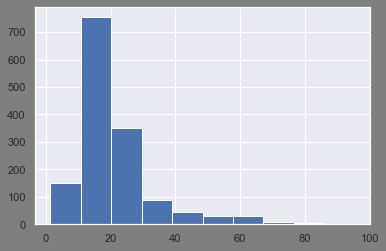

<Figure size 1440x720 with 0 Axes>

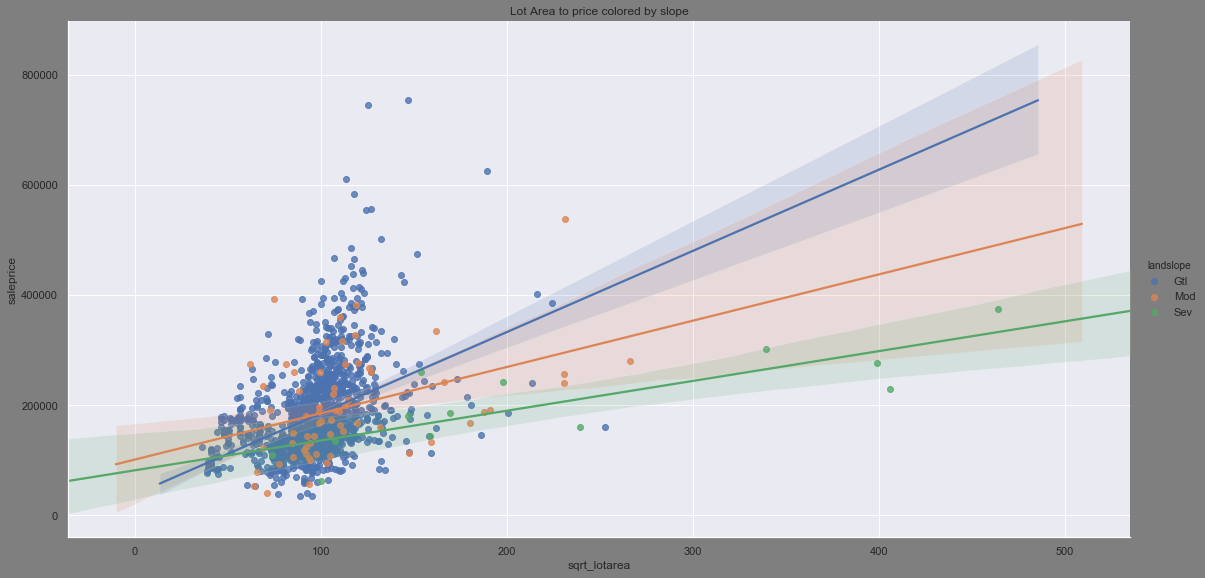

In [759]:
#plot Lot Area and Sale Price grouped by land slope 
#plt.subplot()
#f = house_price_data.loc[house_price_data['landslope'] == 'Gtl']

lot_area_squared= house_price_data['lotarea']#**2


plt.figure(figsize= (20,10))

#sns.scatterplot(x='lotarea',y='sqrt_saleprice',hue ='landslope' , data=house_price_data)
sns.lmplot(x="sqrt_lotarea", y="saleprice", hue="landslope",
               height=8, aspect= 2, data=house_price_data)

#plt.xscale('log')
#plt.yscale('log')
plt.title("Lot Area to price colored by slope")
plt.show()

#

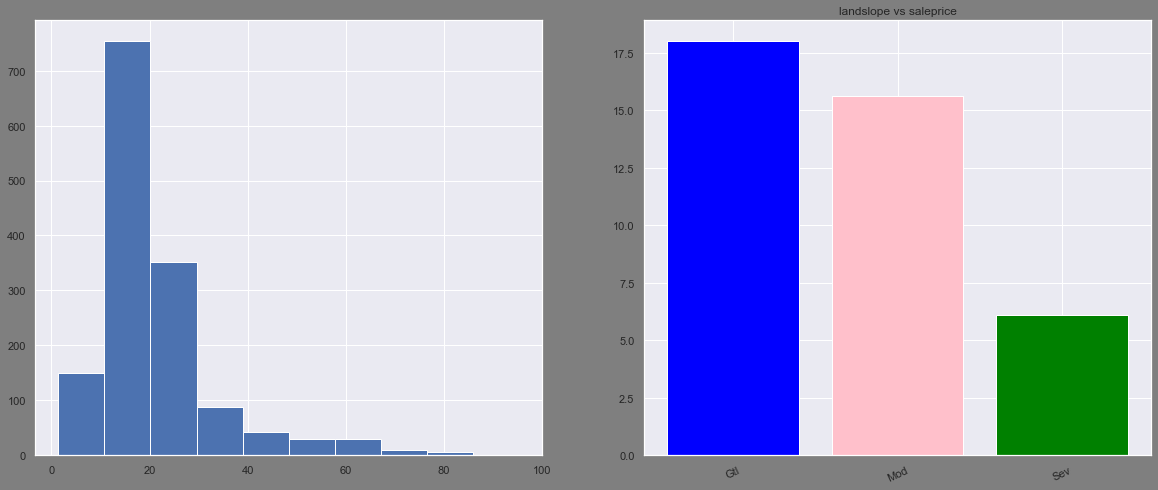

the t-test statistics between Gtl and Mod
Ttest_indResult(statistic=1.8599377670007806, pvalue=0.06309740227777123)
the t-test statistics between Gtl and Sev
Ttest_indResult(statistic=4.307893593203185, pvalue=1.763712893137113e-05)
the t-test statistics between Mod and Sev
Ttest_indResult(statistic=3.1959535250903923, pvalue=0.002030821008709335)


In [766]:
house_price_data['priceper_sfland']= house_price_data['saleprice']/house_price_data['lotarea']

plt.figure(figsize=(20,8))
#plt.hist(log_price)
plt.subplot(1,2,1)
plt.hist(house_price_data['priceper_sfland'])

plt.subplot(1,2,2)
plt.bar(house_price_data.groupby('landslope')['priceper_sfland'].median().index,
        house_price_data.groupby('landslope')["priceper_sfland"].median(),
        color=("blue","pink","green","orange"))
plt.title('{} vs saleprice'.format('landslope'))
#plt.xlabel(catagory)
plt.xticks(rotation=25)

plt.show()

catagories = house_price_data.groupby('landslope')["sqrt_saleprice"].mean().sort_values().index

for var in ["priceper_sfland"]:
        for i in range( len(catagories)):
            t_stats_array=[]
            for j in range(i+1,len(catagories)):
                print('the t-test statistics between {} and {}'.format(catagories[i],catagories[j]))
                print(stats.ttest_ind(
                house_price_data[house_price_data['landslope']==catagories[i]][var], 
                house_price_data[house_price_data['landslope']==catagories[j]][var]))



## Feature Selection 


sqrt_totalspace
house_price_data

Dummy features 

In [550]:
# Dummie Variables 

# land slope Quality 
house_price_data[['Gntl', 'Mod', 'Sev',]] = pd.get_dummies(house_price_data.landslope)

#kitchen Quality 
house_price_data[['Typkitchen', 'Gdkitchen', 'Fakitchen', 'Exkitchen']] = pd.get_dummies(house_price_data.kitchenqual)

#Fire place Quality 
house_price_data[[ 'Porfire', 'Typfire', 'Gdfire', 'Fafire', 'Exfire']] = pd.get_dummies(house_price_data.fireplacequ)

#neighborhood 
house_price_data[['IDOTRR', 'OldTown', 'BrkSide', 'Edwards', 'SWISU', 'Sawyer',
       'MeadowV', 'SawyerW', 'NWAmes', 'BrDale', 'Mitchel', 'NAmes',
       'Crawfor', 'CollgCr', 'Blueste', 'NPkVill', 'ClearCr', 'Timber',
       'Gilbert', 'Somerst', 'NridgHt', 'Blmngtn', 'Veenker', 'StoneBr',
       'NoRidge']] = pd.get_dummies(house_price_data.neighborhood)

# exterior siding 
house_price_data[['Wd Sdng', 'AsbShng', 'VinylSd', 'BrkFace', 'Stucco', 'BrkComm',
       'MetalSd', 'CemntBd', 'Plywood', 'HdBoard', 'WdShing', 'AsphShn',
       'CBlock', 'Stone', 'ImStucc' ]] = pd.get_dummies(house_price_data.exterior1st)

#electrical wiring type 
house_price_data[['FuseA', 'SBrkr', 'FuseF', 'Mix', 'FuseP' ]] = pd.get_dummies(house_price_data.electrical)

#exterior quality 
house_price_data[['TAeterqual', 'FaTAeterqual', 'GdTAeterqual', 'ExTAeterqual' ]] = pd.get_dummies(house_price_data.exterqual)


#garagefinish
house_price_data[['Unf', 'RFn', 'Fin' ]] = pd.get_dummies(house_price_data.garagefinish)

#foundation
house_price_data[['CBlock', 'BrkTil', 'Slab', 'PConc', 'Stone', 'Wood' ]] = pd.get_dummies(house_price_data.foundation)

#bsmtqual
house_price_data[['TA_bsmtqual', 'Fa_bsmtqual', 'Gd_bsmtqual', 'Ex_bsmtqual' ]] = pd.get_dummies(house_price_data.bsmtqual)

#bsmtqual
house_price_data[['TA_bsmtcond', 'Fa_bsmtcond', 'Po_bsmtcond','Gd_bsmtcond' ]] = pd.get_dummies(house_price_data.bsmtcond)


#house_price_data['None', 'BrkFace', 'BrkCmn', 'Stone', None]


In [551]:
#interaction variables 

# interaction between landslope and lot area
house_price_data['Gntl_lotarea'] = house_price_data['Gntl']*house_price_data['lotarea']
house_price_data['Mod_lotarea'] = house_price_data['Mod']*house_price_data['lotarea']
house_price_data['Sev_lotarea'] = house_price_data['Sev']*house_price_data['lotarea']

# interaction between number of fireplaces  and fireplace quality 
house_price_data['Poor_fireplaces']  = house_price_data['Porfire']*house_price_data['fireplaces']
house_price_data['typ_fireplaces']   = house_price_data['Typfire']*house_price_data['fireplaces']
house_price_data['good_fireplaces']  = house_price_data['Gdfire']*house_price_data['fireplaces']
house_price_data['fair_fireplaces']  = house_price_data['Fafire']*house_price_data['fireplaces']
house_price_data['excel_fireplaces'] = house_price_data['Exfire']*house_price_data['fireplaces']

#

house_price_data['quality_of_space'] = house_price_data['sqrt_total_space']*house_price_data['overallqual']


In [552]:
    
''' 'saleprice','sqrt_saleprice','log_saleprice',
                     'mssubclass','lotfrontage','lotarea','sqrt_lotarea', 'log_lotarea'
                              ,'overallqual','overallcond','yearbuilt','yearremodadd'
                              ,'masvnrarea' ,'bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','firstflrsf'       
                                ,'secondflrsf','lowqualfinsf','grlivarea','sqrt_grllivarea','log_grllivarea'
                                ,'total_space', 'sqrt_total_space', 'log_total_space','bsmtfullbath','bsmthalfbath','fullbath','tot_fullbath'       
                                ,'halfbath','tot_halfbath','bedroomabvgr','kitchenabvgr','totrmsabvgrd','fireplaces','garageyrblt'
                                ,'garagecars','garagearea', 'wooddecksf','openporchsf','enclosedporch'    
                                ,'threessnporch','screenporch','poolarea','miscval','mosold','yrsold'
                                ,'median_mothly_homeprice','avg_mothly_homeprice','Month_and_Year'
                                ,'outdoor_space','30yr_mortg_rate''''

SyntaxError: EOL while scanning string literal (<ipython-input-552-e1be414a2ae9>, line 11)

## OLS Regression 

Dummy features 

In [690]:
# Y = target variale 
#Y = house_price_data['log_saleprice']
Y = house_price_data['sqrt_saleprice']
#Y = house_price_data['saleprice']

# https://expertsteaching.com/what-is-dummy-variable-and-dummy-variable-trap/amp/

# X = features for predicting target variable


#X = house_price_data[['PC1','PC2','PC3','PC4','PC5']]


X = house_price_data[['sqrt_total_space','overallqual',
                      'tot_fullbath','garagecars',
                      'yearbuilt','yearremodadd',
                      'totrmsabvgrd','fireplaces',
                      'wooddecksf','log_lotarea',
                      #catagorical dummies
                          #Neighborhood 
                      'IDOTRR',  'Edwards', 'SWISU', 'Sawyer',
                      'SawyerW', 'NWAmes', 'BrDale', 'NAmes',
                      'Crawfor', 'Blueste',  'Timber',
                      'Gilbert', 'Somerst', 'NridgHt', 'Blmngtn',  'StoneBr',
                      #'OldTown','BrkSide','MeadowV','NPkVill',
                      #'ClearCr','Veenker','NoRidge','Mitchel','CollgCr',
                          #kitchen Quality 
                      #'Typkitchen',
                      'Gdkitchen',
                      'Fakitchen',
                      'Exkitchen',
                          #exterior Quality
                      'FaTAeterqual',
                      'GdTAeterqual',
                      'ExTAeterqual',
                      #'TAeterqual'
                      #interaction varaibles    
                         #lot area size and slope
                      'Gntl_lotarea',
                      'Mod_lotarea',
                      #'Sev_lotarea',
                      
                     ]]
    
     #lot area size and slope
#'Gntl_lotarea','Mod_lotarea','Sev_lotarea',
#OldTown, BrkSide, MeadowV, NPkVille, Veenker, NoRidge,


In [691]:
#split into test and training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 132)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [692]:
X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()
results.summary()


#%timeit



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_saleprice   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     250.1
Date:                Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                        19:47:05   Log-Likelihood:                -5605.4
No. Observations:                1168   AIC:                         1.128e+04
Df Residuals:                    1133   BIC:                         1.146e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1351.7937    170.448     -7.931      0.000   -1686.223   -1017.364
sqrt_total_space     2.3727      0.228     10.421      0.000       1.926       2.819
overallqual         14.3529      1.224     11.725      0.000      11.951      16.755
tot_fullbath         9.5352      1.644      5.799      0.000       6.309      12.761
garagecars           9.0102      1.675      5.380      0.000       5.724      12.296
yearbuilt            0.2663      0.064      4.140      0.000       0.140       0.393
yearremodadd         0.3446      0.065      5.314      0.000       0.217       0.472
totrmsabvgrd         3.2610      0.772      4.225      0.000       1.746       4.776
fireplaces           9.8071      1.702      5.761      0.000       6.467      13.147
wooddecksf           0.0262      0.008      3.488      0.001       0.011       0.041
log_lotarea         42.3172      3.124     13.548      0.000      36.189      48.446
IDOTRR             -24.2543      8.912     -2.722      0.007     -41.740      -6.768
Edwards            -19.3647      5.583     -3.469      0.001     -30.318      -8.411
SWISU              -32.1733      7.900     -4.072      0.000     -47.674     -16.672
Sawyer             -30.4400      3.834     -7.940      0.000     -37.962     -22.918
SawyerW            -46.1280      4.542    -10.157      0.000     -55.039     -37.217
NWAmes             -36.3578      4.755     -7.646      0.000     -45.688     -27.027
BrDale             -41.4974      6.695     -6.199      0.000     -54.632     -28.362
NAmes              -40.7521      5.621     -7.250      0.000     -51.781     -29.723
Crawfor            -29.6058      3.691     -8.022      0.000     -36.847     -22.365
Blueste            -30.4249      4.827     -6.303      0.000     -39.896     -20.954
Timber             -36.1424      5.005     -7.221      0.000     -45.963     -26.321
Gilbert            -27.9574      7.423     -3.766      0.000     -42.521     -13.394
Somerst            -34.3700      5.024     -6.841      0.000     -44.228     -24.512
NridgHt            -36.9627      5.080     -7.276      0.000     -46.931     -26.995
Blmngtn            -15.1470      4.597     -3.295      0.001     -24.166      -6.128
StoneBr            -35.0541      6.061     -5.784      0.000     -46.946     -23.162
Gdkitchen          -36.9527      8.050     -4.590      0.000     -52.747     -21.158
Fakitchen          -28.7360      4.416     -6.508      0.000     -37.400     -20.072
Exkitchen          -34.6622      5.035     -6.884      0.000     -44.541     -24.783
FaTAeterqual       -36.2123     12.331     -2.937      0.003     -60.407     -12.018
GdTAeterqual       -18.1101      6.005     -3.016      0.003     -29.892      -6.328
ExTAeterqual       -22.6745      6.762     -3.353      0.001     -35.943      -9.406
Gntl_lotarea        -0.

## Compare to Test Data Set 

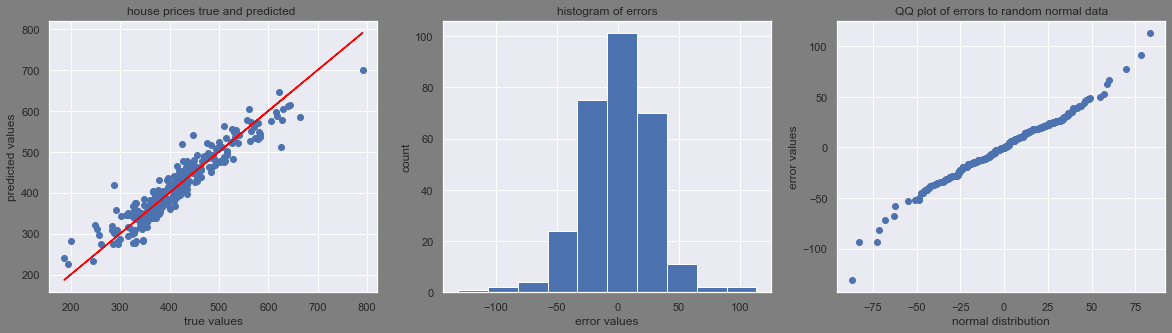

MAE = 21.564457692275877
MSE = 808.3205662492977
RMSE = 28.430978988583874
MAPE = 5.514419718804941


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sqrt_saleprice   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     61.49
Date:                Wed, 12 Feb 2020   Prob (F-statistic):          4.11e-104
Time:                        07:58:57   Log-Likelihood:                -1391.8
No. Observations:                 292   AIC:                             2854.
Df Residuals:                     257   BIC:                             2982.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1189.4277    338.313     -3.516      0.001   -1855.647    -523.209
sqrt_total_space     3.4773      0.474      7.335      0.000       2.544       4.411
overallqual         17.3634      2.438      7.121      0.000      12.562      22.165
tot_fullbath         6.1990      3.258      1.903      0.058      -0.217      12.615
garagecars          18.0650      3.555      5.081      0.000      11.063      25.067
yearbuilt            0.1962      0.131      1.495      0.136      -0.062       0.455
yearremodadd         0.3863      0.127      3.053      0.003       0.137       0.636
totrmsabvgrd        -0.4423      1.758     -0.252      0.802      -3.905       3.021
fireplaces          -0.4669      3.481     -0.134      0.893      -7.322       6.388
wooddecksf           0.0357      0.018      2.020      0.044       0.001       0.070
log_lotarea         17.9489      6.213      2.889      0.004       5.713      30.185
IDOTRR             -41.9575     16.703     -2.512      0.013     -74.851      -9.065
Edwards             -4.4266     13.105     -0.338      0.736     -30.234      21.381
SWISU              -14.6993     13.512     -1.088      0.278     -41.307      11.908
Sawyer             -38.7293      8.947     -4.329      0.000     -56.347     -21.111
SawyerW            -22.2286     10.047     -2.213      0.028     -42.013      -2.444
NWAmes             -38.1060     10.795     -3.530      0.000     -59.363     -16.849
BrDale             -46.6711     15.229     -3.065      0.002     -76.660     -16.682
NAmes              -41.5717     12.478     -3.331      0.001     -66.145     -16.999
Crawfor            -23.4728      8.074     -2.907      0.004     -39.373      -7.573
Blueste            -53.0810      9.672     -5.488      0.000     -72.127     -34.035
Timber             -38.4185     10.822     -3.550      0.000     -59.730     -17.107
Gilbert            -18.4746     20.064     -0.921      0.358     -57.985      21.036
Somerst            -27.9890     10.123     -2.765      0.006     -47.923      -8.055
NridgHt            -34.4720     10.665     -3.232      0.001     -55.474     -13.470
Blmngtn            -19.2230      9.005     -2.135      0.034     -36.957      -1.489
StoneBr            -11.1102     13.157     -0.844      0.399     -37.020      14.799
Gdkitchen          -15.7818     16.390     -0.963      0.337     -48.057      16.494
Fakitchen           -0.0942      9.795     -0.010      0.992     -19.383      19.195
Exkitchen          -13.1310     11.305     -1.162      0.246     -35.393       9.131
FaTAeterqual        -3.9096     23.670     -0.165      0.869     -50.522      42.703
GdTAeterqual       -16.6347     11.922     -1.395      0.164     -40.112       6.843
ExTAeterqual       -15.7130     13.279     -1.183      0.238     -41.862      10.436
Gntl_lotarea         0.

In [774]:
X_test = sm.add_constant(X_test)

results = sm.OLS(Y_test, X_test).fit()

Y_preds = results.predict(X_test)

errors = Y_test - Y_preds
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(Y_test,Y_preds)
plt.plot(Y_test,Y_test,color='red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('house prices true and predicted ')
plt.subplot(1,3,2)
plt.hist(errors)
plt.xlabel('error values')
plt.ylabel('count')
plt.title('histogram of errors')
plt.subplot(1,3,3)
plt.scatter(np.sort(rand_nums), np.sort(errors))
plt.ylabel('error values')
plt.xlabel('normal distribution')
plt.title('QQ plot of errors to random normal data')
plt.show()

print ('MAE = {}'.format(mean_absolute_error(Y_test, Y_preds)))
print ('MSE = {}'.format(mse(Y_test, Y_preds)))
print ('RMSE = {}'.format(rmse(Y_test, Y_preds)))
print ('MAPE = {}'.format(np.mean(np.abs((Y_test - Y_preds)/Y_test))*100))
results.summary()


## Ridge Regression 

In [562]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]


In [572]:
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))

Best alpha value is: 1e-09
R-squared of the model in training set is: 1.0
-----Test set statistics-----
R-squared of the model in test set is: 0.8641021755672021
Mean absolute error of the prediction is: 22.468663052184144
Mean squared error of the prediction is: 1003.4583592769751
Root mean squared error of the prediction is: 31.67741086763524
Mean absolute percentage error of the prediction is: 5.79421404278446


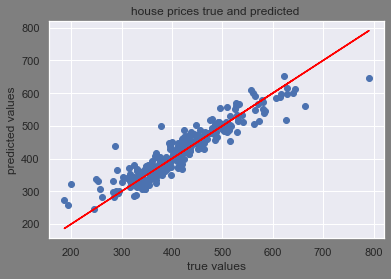

In [573]:
plt.scatter(Y_test,Y_preds_test)
plt.plot(Y_test,Y_test,color='red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('house prices true and predicted ')
plt.show()


In [567]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.9999985360187825
-----Test set statistics-----
R-squared of the model in test set is: 0.8639781195088396
Mean absolute error of the prediction is: 22.47396425491801
Mean squared error of the prediction is: 1004.3743790094645
Root mean squared error of the prediction is: 31.691866133275656
Mean absolute percentage error of the prediction is: 5.794197059619039


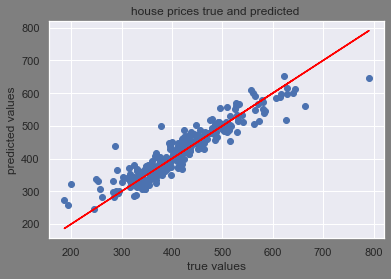

In [568]:
plt.scatter(Y_test,Y_preds_test)
plt.plot(Y_test,Y_test,color='red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('house prices true and predicted ')
plt.show()


In [575]:
from sklearn.linear_model import ElasticNetCV

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.9999985360189316
-----Test set statistics-----
R-squared of the model in test set is: 0.8639781194994607
Mean absolute error of the prediction is: 22.47396425507402
Mean squared error of the prediction is: 1004.3743790787179
Root mean squared error of the prediction is: 31.69186613436826
Mean absolute percentage error of the prediction is: 5.7941970593590675


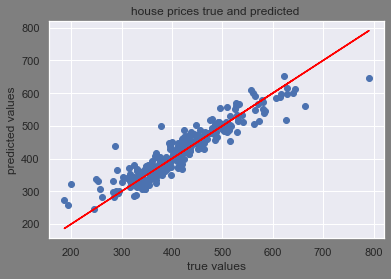

In [576]:
plt.scatter(Y_test,Y_preds_test)
plt.plot(Y_test,Y_test,color='red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('house prices true and predicted ')
plt.show()

## Results

The results from the regresson show that the 'Ordinary Least Square Regression' is the most effective at predicting housing prices with a Test R-squared of 90.4% and a Mean Squared Error Term of ~20
The final equation for our predicitve model is 'The Ridge Lasso' and 'Elestic Net Regressions' resulted in 

$𝑠𝑞𝑟𝑡$(𝑠𝑎𝑙𝑒𝑝𝑟𝑖𝑐𝑒)=−1351.7937+2.3727∗𝑇𝑜𝑡𝑎𝑙𝑠𝑝𝑎𝑐𝑒+14.3529∗𝑜𝑣𝑒𝑟𝑎𝑙𝑙𝑞𝑢𝑎𝑙+9.5352∗𝑡𝑜𝑡𝑓𝑢𝑙𝑙𝑏𝑎𝑡ℎ+9.0102∗𝑔𝑎𝑟𝑎𝑔𝑒𝑐𝑎𝑟𝑠+0.2663∗𝑦𝑒𝑎𝑟𝑏𝑢𝑖𝑙𝑡+0.3446∗𝑦𝑒𝑎𝑟𝑟𝑒𝑚𝑜𝑑𝑎𝑑𝑑+3.2610∗𝑡𝑜𝑡𝑟𝑚𝑠𝑎𝑏𝑣𝑔𝑟𝑑+9.8071∗𝑓𝑖𝑟𝑒𝑝𝑙𝑎𝑐𝑒𝑠+𝑤𝑜𝑜𝑑𝑑𝑒𝑐𝑘𝑠𝑓∗0.0262+𝑙𝑜𝑔𝑙𝑜𝑡𝑎𝑟𝑒𝑎∗42.3172+𝐺𝑒𝑛𝑡𝑙𝑒𝑆𝑙𝑜𝑝𝑒∗𝐿𝑜𝑡𝐴𝑟𝑒𝑎+𝑀𝑜𝑑𝑒𝑟𝑎𝑡𝑒𝑆𝑙𝑜𝑝𝑒∗𝐿𝑜𝑡𝐴𝑟𝑒𝑎+(𝐾𝑖𝑡𝑐ℎ𝑒𝑛𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝐷𝑢𝑚𝑚𝑖𝑒𝑠)(𝐸𝑥𝑡𝑒𝑟𝑖𝑜𝑟𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝐷𝑢𝑚𝑚𝑖𝑒𝑠)+𝐸𝑟𝑟𝑜𝑟𝑇𝑒𝑟𝑚


## Conclusions

Although these results show a strong predictive ability, this model could likely be improved with the incorporation of more data on houses sold on years outside of the 2006-2010 window. A larger sample might improve the significance of categorical variables such as certain neighborhoods and home features that were nearly significant enough to be included in this model. More information on the data would be helpful, since many of the variable descriptions on Kagle were limited often leaving out units of measurement or failing to specify certain aspects of categorical variables. Addresses, Lat/Lon, or GPS coordinants would also be useful, because they might reveal the interactions and influences that ajdacent neighborhoods have on one another. 